# 模型部分

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class NeuralNetwork:
    def __init__(self, num_inputs, num_hiddens, num_outputs, activation='relu'):
        self.num_inputs = num_inputs
        self.num_hiddens = num_hiddens
        self.num_outputs = num_outputs
        self.activation = activation
        self.weights = {
            'W1': np.random.randn(num_inputs, num_hiddens) * 0.01,
            'b1': np.zeros((1, num_hiddens)),
            'W2': np.random.randn(num_hiddens, num_outputs) * 0.01,
            'b2': np.zeros((1, num_outputs))
        }
        self.gradients = {}
        self.activation_fn, self.activation_fn_derivative = self.get_activation_function(activation)
        self.initial_lr = None
        
    def get_activation_function(self, name):
        if name == 'sigmoid':
            return (self.sigmoid, self.sigmoid_derivative)
        elif name == 'tanh':
            return (self.tanh, self.tanh_derivative)
        elif name == 'relu':
            return (self.relu, self.relu_derivative)
        elif name == 'leaky_relu':
            return (self.leaky_relu, self.leaky_relu_derivative)
        else:
            raise ValueError("Unsupported activation function")

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        return self.sigmoid(x) * (1 - self.sigmoid(x))

    def tanh(self, x):
        return np.tanh(x)

    def tanh_derivative(self, x):
        return 1 - np.tanh(x) ** 2

    def relu(self, x):
        return np.maximum(0, x)

    def relu_derivative(self, x):
        return (x > 0).astype(float)

    def leaky_relu(self, x, alpha=0.01):
        return np.where(x > 0, x, x * alpha)

    def leaky_relu_derivative(self, x, alpha=0.01):
        dx = np.ones_like(x)
        dx[x < 0] = alpha
        return dx

    def softmax(self, x):
        e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return e_x / np.sum(e_x, axis=1, keepdims=True)

    def cross_entropy_loss(self, y_pred, y_true, regularization_type=None, reg_lambda=0.01):
        m = y_true.shape[0]
        p = self.softmax(y_pred)
        log_likelihood = -np.log(p[range(m), y_true])
        loss = np.sum(log_likelihood) / m

        if regularization_type == 'L2':
            l2_penalty = reg_lambda / (2 * m) * (np.sum(np.square(self.weights['W1'])) + np.sum(np.square(self.weights['W2'])))
            loss += l2_penalty
        elif regularization_type == 'L1':
            l1_penalty = reg_lambda / m * (np.sum(np.abs(self.weights['W1'])) + np.sum(np.abs(self.weights['W2'])))
            loss += l1_penalty

        return loss

    def forward(self, X):
        Z1 = X.dot(self.weights['W1']) + self.weights['b1']
        A1 = self.activation_fn(Z1)
        Z2 = A1.dot(self.weights['W2']) + self.weights['b2']
        return Z1, A1, Z2

    def backward(self, X, Y, Z1, A1, Z2, regularization_type=None, reg_lambda=0.01):
        m = Y.shape[0]
        grad_Z2 = self.softmax(Z2)
        grad_Z2[range(m), Y] -= 1
        grad_Z2 /= m

        grad_W2 = A1.T.dot(grad_Z2)
        grad_b2 = np.sum(grad_Z2, axis=0, keepdims=True)
        grad_A1 = grad_Z2.dot(self.weights['W2'].T)
        grad_Z1 = grad_A1 * self.activation_fn_derivative(Z1)

        grad_W1 = X.T.dot(grad_Z1)
        grad_b1 = np.sum(grad_Z1, axis=0, keepdims=True)

        if regularization_type == 'L2':
            grad_W1 += reg_lambda / m * self.weights['W1']
            grad_W2 += reg_lambda / m * self.weights['W2']
        elif regularization_type == 'L1':
            grad_W1 += reg_lambda / m * np.sign(self.weights['W1'])
            grad_W2 += reg_lambda / m * np.sign(self.weights['W2'])

        self.gradients = {'W1': grad_W1, 'b1': grad_b1, 'W2': grad_W2, 'b2': grad_b2}

    def update_weights(self, lr):
        for key in self.weights:
            self.weights[key] -= lr * self.gradients[key]

    def predict(self, X):
        _, _, Z2 = self.forward(X)
        return np.argmax(Z2, axis=1)

    def update_learning_rate(self, epoch, decay_rate):
        if self.initial_lr is None:
            self.initial_lr = self.lr  # 保存初始学习率
        self.lr = self.initial_lr * (decay_rate ** epoch)
    
        
    def train(self, train_loader, test_loader, epochs=50, batch_size=100, lr=0.1, decay_rate=0.9, reg_lambda=0.01, regularization_type=None):
        self.lr = lr  # 初始学习率
        self.decay_rate = decay_rate  # 衰减率
        self.reg_lambda = reg_lambda  # 正则化系数
        train_losses = []
        train_accuracies = []
        test_losses = []
        test_accuracies = []

        for epoch in range(epochs):
            self.update_learning_rate(epoch, decay_rate)  # 更新学习率
            
            # Training phase
            total_loss = 0
            correct = 0
            total = 0
            
            for images, labels in train_loader:
                images = images.numpy()  # DataLoader加载的是tensor，转换为numpy
                labels = labels.numpy()
                
                # 进行一次前向传播和反向传播
                Z1, A1, Z2 = self.forward(images)
                self.backward(images, labels, Z1, A1, Z2, regularization_type, reg_lambda)
                self.update_weights(self.lr)  # 使用更新后的学习率
                
                # 计算损失和更新准确率统计
                loss = self.cross_entropy_loss(Z2, labels, regularization_type, reg_lambda)
                total_loss += loss * labels.size
                predicted = self.predict(images)
                correct += (predicted == labels).sum()
                total += labels.shape[0]

            train_losses.append(total_loss / total)
            train_accuracies.append(correct / total)
            
            # Testing phase
            test_loss = 0
            test_correct = 0
            test_total = 0
            
            for images, labels in test_loader:
                images = images.numpy()
                labels = labels.numpy()
                
                _, _, Z2 = self.forward(images)
                loss = self.cross_entropy_loss(Z2, labels, regularization_type, reg_lambda)
                test_loss += loss * labels.size
                predicted = self.predict(images)
                test_correct += (predicted == labels).sum()
                test_total += labels.shape[0]

            test_losses.append(test_loss / test_total)
            test_accuracies.append(test_correct / test_total)
            
            print(f'Epoch {epoch+1}: Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}, '
                  f'Test Loss: {test_losses[-1]:.4f}, Test Accuracy: {test_accuracies[-1]:.4f}')

        return train_losses, train_accuracies, test_losses, test_accuracies

    def evaluate(self, test_loader):
        test_loss = 0
        test_correct = 0
        test_total = 0
        for images, labels in test_loader:
            images = images.numpy()
            labels = labels.numpy()
            _, _, Z2 = self.forward(images)
            loss = self.cross_entropy_loss(Z2, labels)
            test_loss += loss * labels.size
            predicted = self.predict(images)
            test_correct += (predicted == labels).sum()
            test_total += labels.shape[0]
        return test_loss / test_total, test_correct / test_total


In [3]:
def plot_metrics(train_losses, train_accuracies, test_losses, test_accuracies):
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'r-', label='Train Loss')
    plt.plot(epochs, test_losses, 'b--', label='Test Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'r-', label='Train Accuracy')
    plt.plot(epochs, test_accuracies, 'b--', label='Test Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [4]:
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from torch.utils.data import DataLoader

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),  # 将图像转换为Tensor
    transforms.Lambda(lambda x: torch.flatten(x))  # 展平图像
])

# 加载数据集
mnist_train = torchvision.datasets.FashionMNIST(
    root="../data", train=True, transform=transform, download=True)
mnist_test = torchvision.datasets.FashionMNIST(
    root="../data", train=False, transform=transform, download=True)

# 创建数据加载器
train_loader = DataLoader(mnist_train, batch_size=256, shuffle=True)
test_loader  = DataLoader(mnist_test, batch_size=256, shuffle=False)

In [8]:
len(mnist_train), len(mnist_test)

(60000, 10000)

In [9]:
mnist_train[0][0].shape

torch.Size([784])

# 参数查找

In [17]:
import numpy as np
import copy

def grid_search(train_loader, test_loader, param_grid):
    best_params = {}
    best_accuracy = 0
    best_model_weights = None

    for lr in param_grid['lr']:
        for decay_rate in param_grid['decay_rate']:
            for reg_lambda in param_grid['reg_lambda']:
                for batch_size in param_grid['batch_size']:
                    for regularization_type in param_grid['regularization_type']:
                        for num_hiddens in param_grid['num_hiddens']:
                            net = NeuralNetwork(784, num_hiddens, 10, activation='relu')
                            net.train(train_loader, test_loader, epochs=20, batch_size=batch_size, lr=lr, decay_rate=decay_rate, reg_lambda=reg_lambda, regularization_type=regularization_type)
                            _, accuracy = net.evaluate(test_loader)
                            if accuracy > best_accuracy:
                                best_accuracy = accuracy
                                best_params = {
                                    'lr': lr,
                                    'decay_rate': decay_rate,
                                    'reg_lambda': reg_lambda,
                                    'batch_size': batch_size,
                                    'regularization_type': regularization_type,
                                    'num_hiddens': num_hiddens
                                }
                                best_model_weights = copy.deepcopy(net.weights)
                            print(f"Tested with lr={lr}, decay_rate={decay_rate}, reg_lambda={reg_lambda}, batch_size={batch_size}, regularization_type={regularization_type}, num_hiddens={num_hiddens}: Accuracy = {accuracy:.4f}")

    print(f"Best parameters: {best_params}")
    return best_params, best_model_weights




In [19]:
# 设置超参数网格
param_grid = {
    'lr': [0.05, 0.1],
    'decay_rate': [0.9, 0.99],
    'reg_lambda': [0.01, 0.1],
    'batch_size': [32, 64, 128],
    'regularization_type': ['L1', 'L2'],
    'num_hiddens': [256]  
}

# 运行网格搜索
best_params, best_model_weights = grid_search(train_loader, test_loader, param_grid)

Epoch 1: Train Loss: 1.3834, Train Accuracy: 0.5953, Test Loss: 0.9024, Test Accuracy: 0.6950
Epoch 2: Train Loss: 0.7968, Train Accuracy: 0.7498, Test Loss: 0.7849, Test Accuracy: 0.7285
Epoch 3: Train Loss: 0.6924, Train Accuracy: 0.7965, Test Loss: 0.6905, Test Accuracy: 0.7818
Epoch 4: Train Loss: 0.6378, Train Accuracy: 0.8154, Test Loss: 0.6651, Test Accuracy: 0.7918
Epoch 5: Train Loss: 0.6064, Train Accuracy: 0.8251, Test Loss: 0.6355, Test Accuracy: 0.8043
Epoch 6: Train Loss: 0.5861, Train Accuracy: 0.8318, Test Loss: 0.6067, Test Accuracy: 0.8178
Epoch 7: Train Loss: 0.5720, Train Accuracy: 0.8350, Test Loss: 0.6021, Test Accuracy: 0.8147
Epoch 8: Train Loss: 0.5610, Train Accuracy: 0.8387, Test Loss: 0.5890, Test Accuracy: 0.8182
Epoch 9: Train Loss: 0.5523, Train Accuracy: 0.8407, Test Loss: 0.5791, Test Accuracy: 0.8234
Epoch 10: Train Loss: 0.5454, Train Accuracy: 0.8418, Test Loss: 0.5745, Test Accuracy: 0.8260
Epoch 11: Train Loss: 0.5401, Train Accuracy: 0.8434, Test 

# 最优模型训练可视化

In [14]:
num_inputs, num_hiddens, num_outputs = 784, 256, 10
netbest = NeuralNetwork(num_inputs, num_hiddens, num_outputs)

train_losses, train_accuracies, test_losses, test_accuracies = netbest.train(train_loader, test_loader, epochs = 100, lr= 0.1, decay_rate = 0.99, reg_lambda = 0.1 ,batch_size = 32, regularization_type='L2')

Epoch 1: Train Loss: 1.0493, Train Accuracy: 0.6564, Test Loss: 0.7095, Test Accuracy: 0.7387
Epoch 2: Train Loss: 0.6108, Train Accuracy: 0.8014, Test Loss: 0.6144, Test Accuracy: 0.7753
Epoch 3: Train Loss: 0.5299, Train Accuracy: 0.8303, Test Loss: 0.5595, Test Accuracy: 0.8018
Epoch 4: Train Loss: 0.4958, Train Accuracy: 0.8418, Test Loss: 0.5526, Test Accuracy: 0.7971
Epoch 5: Train Loss: 0.4697, Train Accuracy: 0.8510, Test Loss: 0.4902, Test Accuracy: 0.8321
Epoch 6: Train Loss: 0.4507, Train Accuracy: 0.8584, Test Loss: 0.4840, Test Accuracy: 0.8282
Epoch 7: Train Loss: 0.4375, Train Accuracy: 0.8618, Test Loss: 0.4781, Test Accuracy: 0.8328
Epoch 8: Train Loss: 0.4290, Train Accuracy: 0.8660, Test Loss: 0.4523, Test Accuracy: 0.8437
Epoch 9: Train Loss: 0.4171, Train Accuracy: 0.8711, Test Loss: 0.4462, Test Accuracy: 0.8446
Epoch 10: Train Loss: 0.4073, Train Accuracy: 0.8733, Test Loss: 0.4761, Test Accuracy: 0.8349
Epoch 11: Train Loss: 0.4006, Train Accuracy: 0.8769, Test 

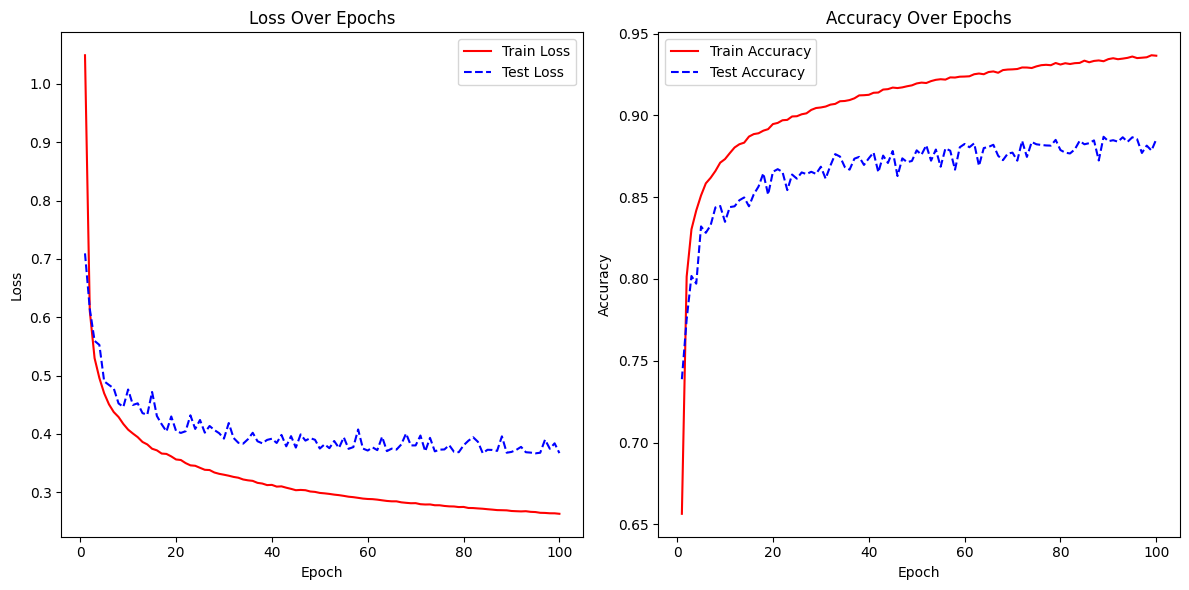

In [15]:
plot_metrics(train_losses, train_accuracies, test_losses, test_accuracies)

## 网络参数可视化

保存最佳模型

In [8]:
def save_model_weights(network, filename='model_weights.npz'):
    np.savez(filename, **network.weights)

def load_model_weights(network, filename='model_weights.npz'):
    data = np.load(filename)
    for key in data.files:
        network.weights[key] = data[key]

In [16]:
save_model_weights(netbest)

网络参数可视化

In [10]:
def plot_weight_histogram(network):
    for key, weight in network.weights.items():
        plt.hist(weight.ravel(), bins=50)
        plt.title(f'Weight Histogram for {key}')
        plt.xlabel('Weight values')
        plt.ylabel('Frequency')
        plt.show()

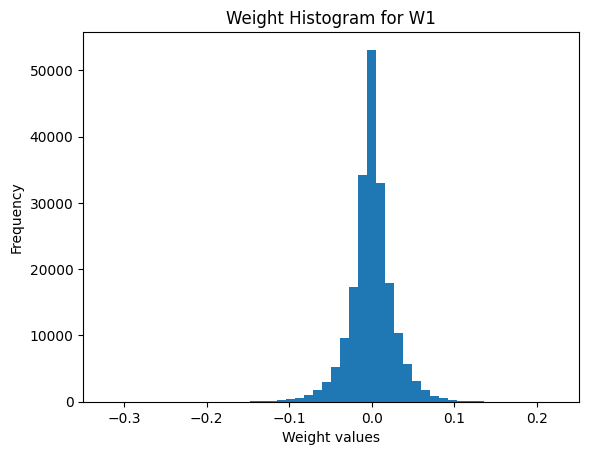

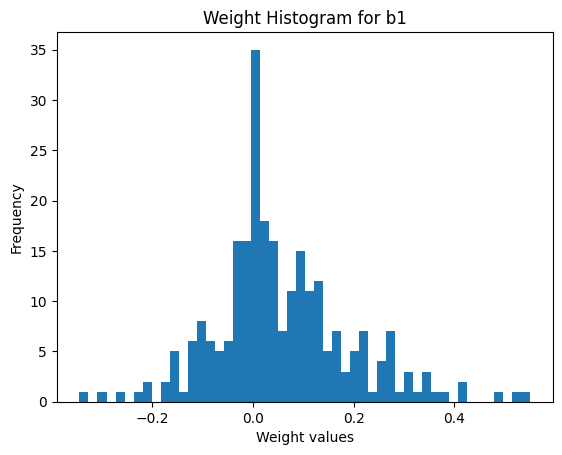

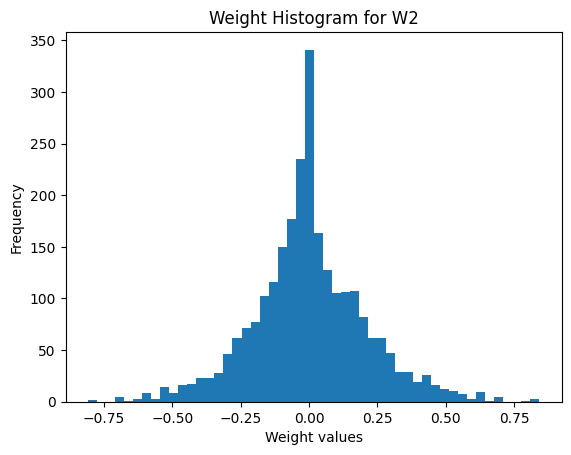

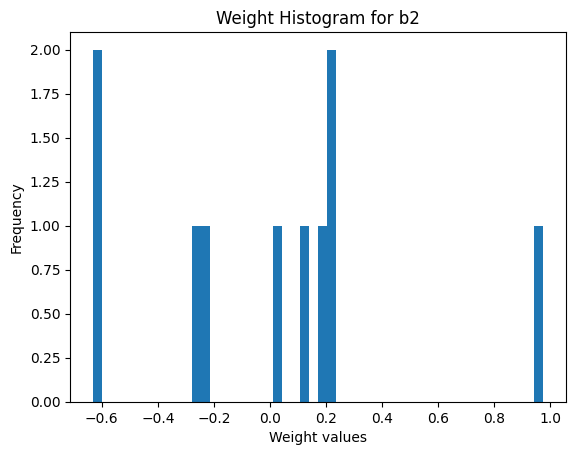

In [17]:
plot_weight_histogram(netbest)

In [12]:
def plot_weight_heatmap(network):
    for key, weight in network.weights.items():
        plt.imshow(weight, aspect='auto', cmap='viridis')
        plt.colorbar()
        plt.title(f'Heatmap for {key} weights')
        plt.xlabel('Neurons in next layer')
        plt.ylabel('Neurons in current layer')
        plt.show()

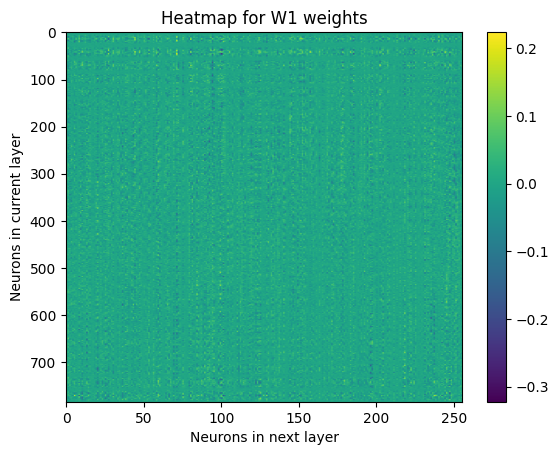

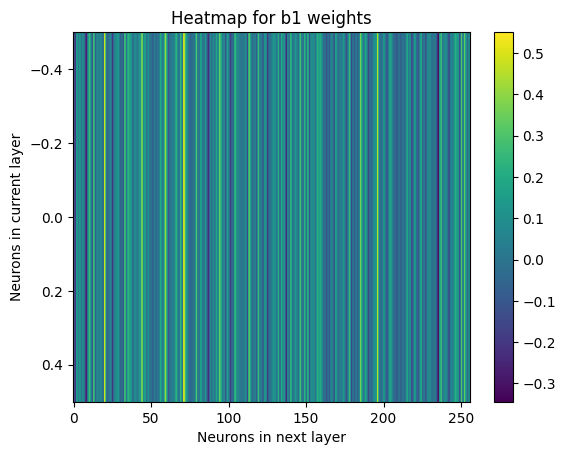

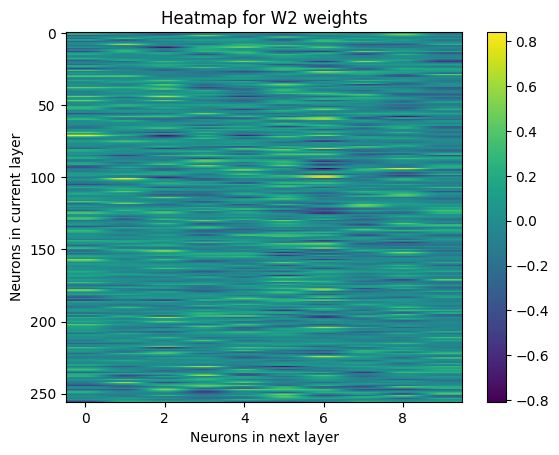

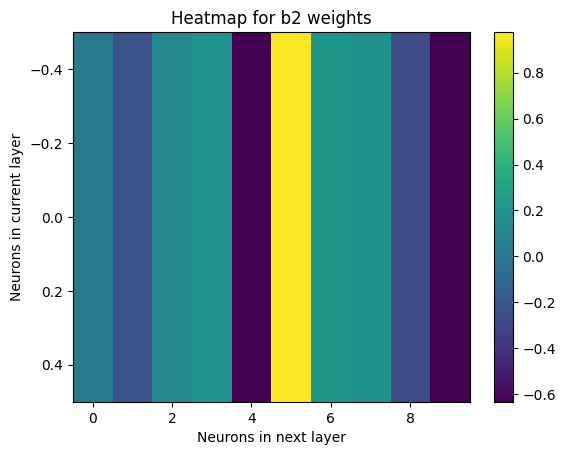

In [18]:
plot_weight_heatmap(netbest)

模型评测

In [19]:
model = NeuralNetwork(num_inputs, num_hiddens, num_outputs, activation='relu')
load_model_weights(model, filename='model_weights.npz')

In [20]:
test_loss, test_accuracy = model.evaluate(test_loader)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.3169, Test Accuracy: 0.8854
